In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, concatenate, Dropout
from tensorflow.keras.models import Model
import gym
from time import time,sleep
sns.set_style("darkgrid")

/home/raphael/rl_introduction/venv/lib/python3.6/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
env = gym.make('FrozenLake-v0')

In [3]:
class Agent:
    def __init__(self, env):
        self.env = env
    def act(self, state):
        pass
    def train(self, next_state, reward, done): 
        pass

In [4]:
class AgentRandom(Agent):
    def act(self, state):
        return self.env.action_space.sample()

In [5]:
class RunAgentEnv:
    def __init__(self, agent, env, nb_step):
        self.agent = agent
        self.env = env
        self.nb_step = nb_step
        self.rewards = np.zeros(nb_step)
        self.cum_reward_per_episode = [[]]
        self.actions = np.zeros(nb_step)
    def run_experiment(self, is_train=True):
        state = self.env.reset()
        for i in range(self.nb_step):
            action = self.agent.act(state)
            state, reward, done, info = self.env.step(action)
            if is_train == True:
                self.agent.train(state, reward, done)
            if done is True:
                state = self.env.reset()
                self.cum_reward_per_episode.append([])
                
            self.actions[i] = action
            self.rewards[i] = reward
            self.cum_reward_per_episode[-1].append(reward)
        episode_rewards = [sum(ep) for ep in run.cum_reward_per_episode]
        return self.rewards, episode_rewards

In [6]:
agent_rand = AgentRandom(env)

In [7]:
run = RunAgentEnv(agent_rand, env, 1000)

In [8]:
rewards, ep_rewards = run.run_experiment()

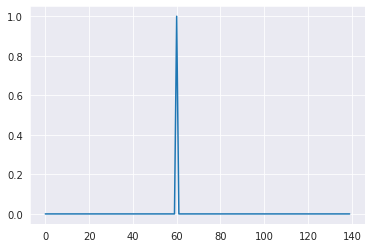

In [9]:
plt.plot(ep_rewards)

In [10]:
class AgentDeepQ(Agent):
    def __init__(self, env):
        super(AgentDeepQ, self).__init__(env)
        self.gamma = 0.95    # discount rate
        self.action_shape = env.action_space.n
        self.state_shape = env.observation_space.shape[0]
        self.model = self._build_model()
        
        self.state = None
        self.action = None
        self.predicted_Q = None
        
    def _build_model(self):
        input_state = Input(name='input_state', shape=(self.state_shape,), dtype='float32')
        input_action = Input(name='input_action', shape=(self.action_shape,), dtype='float32')
        x = concatenate([input_state, input_action])
        x = Dense(4, activation='relu')(x)
        x = Dense(1, activation='linear')(x)
        model = Model(inputs=[input_state, input_action], outputs=x)
        model.compile(loss='mse')
        return model
    
    def act(self, state):
        self.state = state
        _state = np.tile(state, (self.action_shape,1))
        _action = np.identity(self.action_shape)
        predicted_Qs = self.model.predict([_state, _action])
        self.action = np.argmax(self.model.predict) 
        self.predicted_Q = predicted_Qs[self.action]
        return self.action
    
    def train(self, next_state, reward, done):
        _next_state = np.tile(next_state, (self.action_shape,1))
        _next_action = np.identity(self.action_shape)
        predicted_Qs_next_state = self.model.predict([_next_state, _next_action])
        predicted_Q_next_state = np.max(predicted_Qs_next_state)
        if done is True:
            target = reward
        else:
            target = reward + self.gamma * predicted_Q_next_state
        _action = np.zeros(self.action_shape)
        _action[self.action] = 1
        self.model.fit([self.state.reshape(1,-1),_action.reshape(1,-1)], np.array([target]))

In [11]:
env.observation_space

Discrete(16)

In [12]:
class AgentDeepQEpsilon(Agent):
    def __init__(self, env, eps = 0.1):
        super(AgentDeepQEpsilon, self).__init__(env)
        self.gamma = 0.99    # discount rate
        self.eps = eps
        self.action_shape = env.action_space.n
        self.state_shape = env.observation_space.shape[0]
        self.model = self._build_model()
        
        self.state = None
        self.action = None
        self.predicted_Q = None
        
    def _build_model(self):
        input_state = Input(name='input_state', shape=(self.state_shape,), dtype='float32')
        input_action = Input(name='input_action', shape=(self.action_shape,), dtype='float32')
        x = concatenate([input_state, input_action])
        x = Dense(8, activation='relu')(x)
        x = Dense(8, activation='relu')(x)
        x = Dense(4, activation='relu')(x)
        x = Dense(1, activation='linear')(x)
        model = Model(inputs=[input_state, input_action], outputs=x)
        model.compile(loss='mse')
        return model
    
    def act(self, state):
        self.state = state
        if np.random.rand() < self.eps:
            self.action = np.random.randint(self.action_shape)
            return self.action
        _state = np.tile(state, (self.action_shape,1))
        _action = np.identity(self.action_shape)
        predicted_Qs = self.model.predict([_state, _action])
        self.action = np.argmax(predicted_Qs) 
        self.predicted_Q = predicted_Qs[self.action]
        return self.action
    
    def train(self, next_state, reward, done):
        _next_state = np.tile(next_state, (self.action_shape,1))
        _next_action = np.identity(self.action_shape)
        predicted_Qs_next_state = self.model.predict([_next_state, _next_action])
        predicted_Q_next_state = np.max(predicted_Qs_next_state)
        if done is True:
            target = reward
        else:
            target = reward + self.gamma * predicted_Q_next_state
        _action = np.zeros(self.action_shape)
        _action[self.action] = 1
        self.model.fit([self.state.reshape(1,-1),_action.reshape(1,-1)], np.array([target]), batch_size=1, verbose=0, shuffle=False)

In [13]:
class AgentDeepQEpsilonReplayMemory(Agent):
    def __init__(self, env, eps = 0.1, len_memory=500):
        super(AgentDeepQEpsilon, self).__init__(env)
        self.gamma = 0.99    # discount rate
        self.eps = eps
        self.action_shape = env.action_space.n
        self.state_shape = env.observation_space.shape[0]
        self.model = self._build_model()
        self.len_memory = len_memory
        self.memory = np.zeros(())
        
        self.state = None
        self.action = None
        self.predicted_Q = None
        
    def _build_model(self):
        input_state = Input(name='input_state', shape=(self.state_shape,), dtype='float32')
        input_action = Input(name='input_action', shape=(self.action_shape,), dtype='float32')
        x = concatenate([input_state, input_action])
        x = Dense(16, activation='relu')(x)
        x = Dense(8, activation='relu')(x)
        x = Dense(1, activation='linear')(x)
        model = Model(inputs=[input_state, input_action], outputs=x)
        model.compile(loss='mse')
        return model
    
    def act(self, state):
        self.state = state
        if np.random.rand() < 0.1:
            self.action = np.random.randint(self.action_shape)
            return self.action
        _state = np.tile(state, (self.action_shape,1))
        _action = np.identity(self.action_shape)
        predicted_Qs = self.model.predict([_state, _action])
        self.action = np.argmax(self.model.predict) 
        self.predicted_Q = predicted_Qs[self.action]
        return self.action
    
    def train(self, next_state, reward, done):
        _next_state = np.tile(next_state, (self.action_shape,1))
        _next_action = np.identity(self.action_shape)
        predicted_Qs_next_state = self.model.predict([_next_state, _next_action])
        predicted_Q_next_state = np.max(predicted_Qs_next_state)
        if done is True:
            target = reward
        else:
            target = reward + self.gamma * predicted_Q_next_state
        _action = np.zeros(self.action_shape)
        _action[self.action] = 1
        self.model.fit([self.state.reshape(1,-1),_action.reshape(1,-1)], np.array([target]), batch_size=1, verbose=0, shuffle=False)

In [14]:
class AgentDeepQEpsilon2(Agent):
    def __init__(self, env, eps = 0.1):
        super(AgentDeepQEpsilon2, self).__init__(env)
        self.gamma = 0.99    # discount rate
        self.eps = eps
        self.action_shape = env.action_space.n
        self.state_shape = env.observation_space.n #shape[0]
        self.model = self._build_model()
        
        self.state = None
        self.action = None
        self.predicted_Q = None
        
    def _build_model(self):
        input_state = Input(name='input_state', shape=(self.state_shape,), dtype='float32')
        x = Dense(16, activation='relu')(input_state)
        x = Dense(self.action_shape, activation='linear')(x)
        model = Model(inputs=input_state, outputs=x)
        model.compile(loss='mse')
        return model
    
    def act(self, state):
        _ = np.zeros(self.state_shape)
        _[state] = 1
        state = _
        self.state = state
        self.predicted_Q = self.model.predict(state.reshape(1,-1))[0]
        if np.random.rand() < self.eps:
            self.action = np.random.randint(self.action_shape)
            return self.action
        self.action = np.argmax(self.predicted_Q) 
        return self.action
    
    def train(self, next_state, reward, done):
        _ = np.zeros(self.state_shape)
        _[next_state] = 1
        next_state = _
        predicted_Q_next_state = self.model.predict(next_state.reshape(1,-1))[0]
        target = self.predicted_Q
        if done is True:
            target[self.action] = reward
        else:
            target[self.action] = reward + self.gamma * max(predicted_Q_next_state)
        self.model.fit(self.state.reshape(1,-1), target.reshape(1,-1), batch_size=1, verbose=0, shuffle=False)

In [15]:
agent_deepQ_epsilon2 = AgentDeepQEpsilon2(env)

In [16]:
run = RunAgentEnv(agent_deepQ_epsilon2, env, 20000)

In [17]:
rewards, ep_rewards = run.run_experiment()

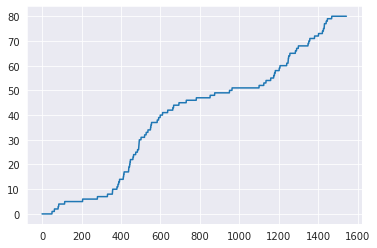

In [22]:
plt.plot(np.cumsum(ep_rewards))

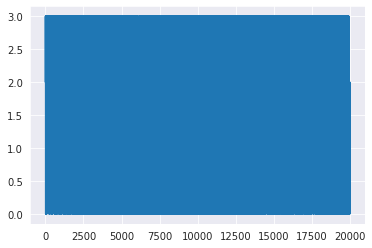

In [19]:
plt.plot(run.actions)

In [20]:
env.step(0)

(5, 0.0, True, {'prob': 0.3333333333333333})